In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encode = nn.Sequential(
            # ..
            nn.Linear(784 ,300),
            nn.Linear(300 ,64)
        )
        
        self.decode = nn.Sequential(
            # ...
            nn.Sigmoid(),
            nn.Linear(64 ,300),
            nn.Linear(300 ,784)
            # картинки -- это тензоры со значениями от 0 до 1
            # нет особого смысла выводить что-то не из этого промежутка
        )
    
    def forward(self, x):
        return self.decode(self.encode(x))

In [7]:
def get_loader(train, batch_size):
    '''Cкачает мнист и сохранит где-то рядом.'''
    
    # Dataset в PyTorch -- это какой-то объект, который оборачивает сырые данные и делает с ними какой-нибудь препроцессинг
    dataset = datasets.MNIST('mnist', train=train, download=True,
        transform=transforms.ToTensor())
    
    # DataLoader делает из датасета генератор, который возвращает данные, сгруппированные по батчам
    loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return loader
    
train = get_loader(True, 64)
val = get_loader(False, 64)

In [9]:
# device = torch.device("cuda:2" if torch.cuda.is_available() else "cpu")
model=Autoencoder()
model = nn.DataParallel(model)


# train = train.to(device)

In [10]:
model = Autoencoder()
criterion = torch.nn.MSELoss()
#                    ^ попробуйте также другие меры разности (например, абсолютную ошибку)
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(10):
    train_loss = 0
    for data, _ in train:
        #     ^ лэйблы нам не нужны
        data = data.view(-1, 784)
        
        optimizer.zero_grad()
        
        reconstructed = model(data)
        loss = criterion(data, reconstructed)
        
        loss.backward()

        train_loss += loss.item()
        optimizer.step()

    print('epoch %d, loss %.4f' % (epoch, train_loss / len(train)))

epoch 0, loss 0.0199
epoch 1, loss 0.0103
epoch 2, loss 0.0099
epoch 3, loss 0.0097
epoch 4, loss 0.0096
epoch 5, loss 0.0096
epoch 6, loss 0.0096
epoch 7, loss 0.0096
epoch 8, loss 0.0096
epoch 9, loss 0.0095


In [11]:
from matplotlib import animation
from matplotlib.animation import FuncAnimation
from IPython.display import HTML, display

def get(x):
    return train.dataset[x][0].view(1, 784)

def imshow(img):
    pic = img.numpy().astype('float')
    plt.axis('off')
    return plt.imshow(pic, cmap='Greys', animated=True)

def morph(inputs, steps, delay):
    # перегоняем в латентное пространство все картинки на входе
    latent = [model.encode(get(k)).data for k in inputs]
    fig = plt.figure()
    images = []
    for a, b in zip(latent, latent[1:] + [latent[0]]):
        for t in numpy.linspace(0, 1, steps):
            # получаем проинтерполированную точку
            c = a*(1-t)+b*t
            # ...и декодируем её в изображение
            morphed = model.decode(c).data
            morphed = morphed.view(28, 28)
            images.append([imshow(morphed)])
    
    ani = animation.ArtistAnimation(fig, images, interval=delay)

    display(HTML(ani.to_html5_video()))

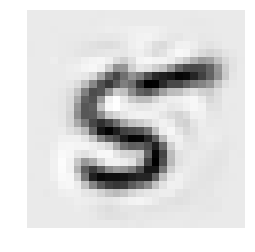

In [12]:
import numpy
morph(numpy.random.randint(0, len(train.dataset), 30), 20, 30)